# 5 - Deep probabilistic neural network in TensorFlow 2.0





Now that we've seen how easy it is to train an image classification network in TensorFlow `keras`, let's explore making that network probabilistic using TensorFlow Probability.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from typing import Optional

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.0.0


In [2]:
checkpoint_path = 'saved_models/mnist_fashion.ckpt'  # Ignore for now.

## Image Classification

We've seen how to solve simple regression problems in TensorFlow 2.0 and the Keras layers library, but how about doing something deeper? What about image classification?

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's verify that this is the same data that we saw a moment ago.

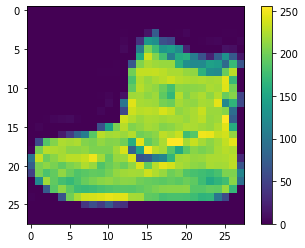

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Standardize the r/g/b pixel values to between zero and one.

In [5]:
train_images = train_images / 255.0  # Divide by float to ensure that we don't suffer from default integer casting.
test_images = test_images / 255.0

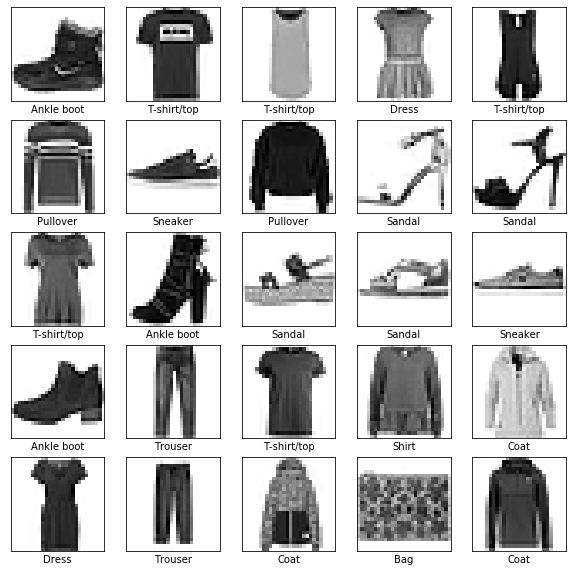

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

We've already built a deep neural network for these data -- let's adjust it to be probabilistic this time.

In [7]:
def posterior_mean_field(kernel_size: int, bias_size: Optional[int] = 0, dtype: Optional[str] = None) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])


def prior_trainable(kernel_size: int, bias_size: Optional[int] = 0, dtype: Optional[str] = None) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])


model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    tfp.layers.DenseVariational(128, 
                                activation='relu', 
                                make_posterior_fn=posterior_mean_field, 
                                make_prior_fn=prior_trainable),
    keras.layers.Dense(10, activation='softmax')
])

For a loss function, we'll choose categorical cross entropy loss between logit outputs and labels -- this is a great loss function for mutually exclusive discrete classification tasks.

In [8]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Because I'm using the `categorical_crossentropy` loss here, I need to binarize my training labels. Fortunately, TensorFlow Keras provides an easy utility function for that.

In [9]:
binary_train_labels = tf.keras.utils.to_categorical(train_labels)
binary_train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_variational (DenseVari (None, 128)               301440    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 302,730
Trainable params: 302,730
Non-trainable params: 0
_________________________________________________________________


Almost triple the number of parameters that were in our previous model. This might be a use case for hardware acceleration.

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(train_images, binary_train_labels, epochs=15, callbacks=[])

Train on 60000 samples
Epoch 1/15
28736/60000 [=============>................] - ETA: 12s - loss: 727.0111 - accuracy: 0.1118

KeyboardInterrupt: 

The last time we ran this (non-probabilistically), each epoch took about 5 seconds to train. This time, it looks like 4-5x that.

Since nobody's boss paid for them to be here to watch a model train on my laptop's CPU, I went ahead and pre-trained this one for ~40 epochs and saved it to disk. Let's load that instead.

In [12]:
model.load_weights(checkpoint_path)

In [13]:
test_loss, test_acc = model.evaluate(test_images,  tf.keras.utils.to_categorical(test_labels), verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 1s - loss: 731.8916 - accuracy: 0.5055

Test accuracy: 0.5055


So, even though the model trained slowly, we've at least got something that we can work with that's right over half the time. Note that we're still not performing quite at the level that we reached with the simple densely-connected model. That likely has to do with the intense regularization we're applying in the form of Bayesian priors on the model weights.

In [14]:
predictions = model.predict(test_images)
predictions[0], predictions[1]

(array([2.9257328e-05, 1.3619868e-08, 4.4158038e-05, 3.9039169e-06,
        2.1878292e-05, 1.4739175e-01, 3.2139629e-05, 4.2932894e-02,
        3.5874328e-01, 4.5080072e-01], dtype=float32),
 array([8.2754996e-06, 3.4271775e-08, 5.0295919e-01, 3.0647408e-07,
        4.0982115e-01, 1.2610047e-15, 8.4179342e-02, 5.0295264e-19,
        3.0317700e-03, 1.1453935e-22], dtype=float32))

Predictions work the same as in the regular dense model -- we get a softmax output of activations for each potential class in the problem.

Our softmax function effectively squished the model outputs into a distribution and seems to be most heavily activated on class 9 for the first test image. Let's verify that.

In [15]:
np.argmax(predictions[0])

9

Alright, and what was the true label?

In [16]:
test_labels[0]

9

Success! At least from this draw, we got this one correct. Let's visualize this.

In [17]:
def plot_image(i: int, predictions_array: np.ndarray, true_label: np.ndarray, img: np.ndarray):
    """
    Plot an image from the passed set, along with its true and predicted label.
    """
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i: int, predictions_array: np.ndarray, true_label: np.ndarray):
    """
    Plot a bar chart of the model activations for each class pertaining to a given image.
    """
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

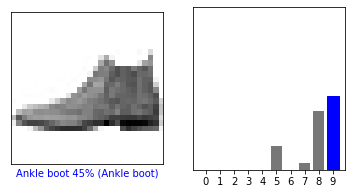

In [18]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's try that again, given our model's propensity to overstate its confidence.

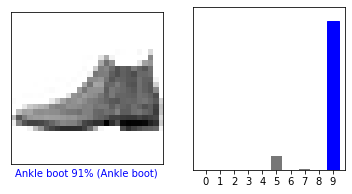

In [19]:
predictions = model.predict(test_images)
predictions[0], predictions[1]

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

As we suspected, the confidence value changed.

Let's check out the rest of the first 15 images in the test set.

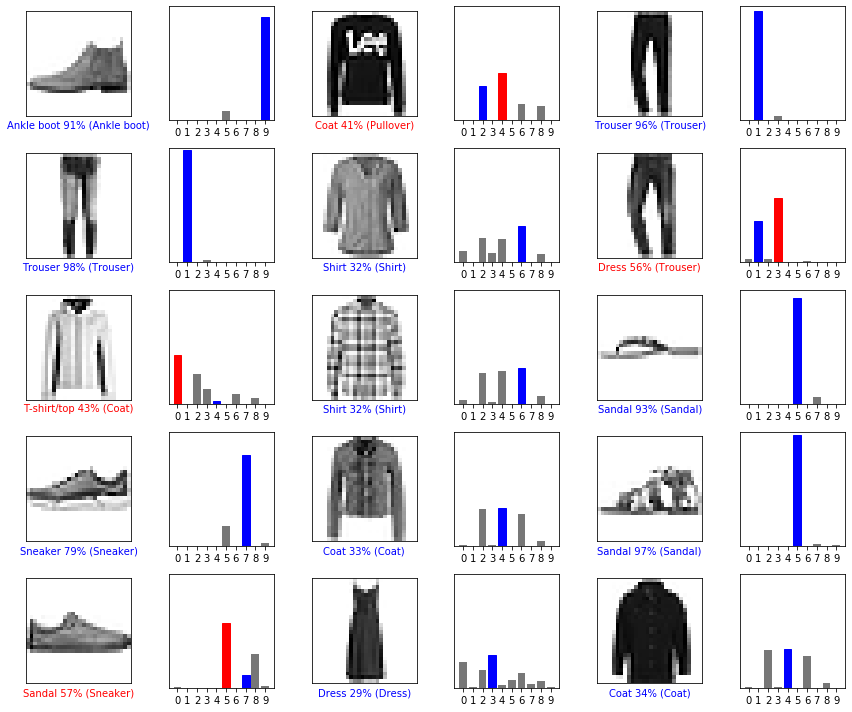

In [20]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels)
    
plt.tight_layout()
plt.show()

So the model missed on a solid chunk of these (at least in this draw). Let's explore the special capability that this probabilistic model has over a point-estimate, though -- epistemic uncertainty.

## Evaluate uncertainties

Remember, we instantiated this model using a probabilistic layer, so we running multiple prediction instances through the model leads to multiple output results. Let's demonstrate this to find the least-certain item of clothing in the first two hundred images.

First, we'll generate 100 predictions for each of the first 500 images in the test set.

In [21]:
yhats = [model.predict(test_images[:500]) for _ in range(100)]

Let's group the predictions for each test image together and cast to a Pandas `DataFrame`.

In [22]:
first_five_hundred_preds = [pd.DataFrame([yhat[i] for yhat in yhats]) for i in range(500)]

In [23]:
first_five_hundred_preds[0]

,0,1,2,3,4,5,6,7,8,9
0,9.935153e-12,6.789069e-15,1.672446e-13,6.816873e-12,1.025879e-13,0.005412,3.625581e-13,0.002977,0.000002,0.991609
1,1.339484e-09,5.420360e-14,3.442658e-10,1.894336e-10,1.038911e-11,0.022238,5.499716e-10,0.005424,0.000514,0.971824
2,1.316413e-06,2.264400e-09,3.150682e-06,5.416742e-07,5.209408e-07,0.017879,5.428515e-06,0.008814,0.004462,0.968834
3,1.643350e-12,1.129071e-16,1.039219e-13,1.533366e-13,1.202868e-14,0.003837,1.979631e-13,0.001193,0.000004,0.994967
4,3.471284e-08,1.598736e-09,8.320219e-09,1.504784e-07,5.190538e-09,0.116539,1.389717e-08,0.056115,0.001326,0.826020
...,...,...,...,...,...,...,...,...,...,...
95,5.359990e-07,5.721025e-10,3.475571e-08,2.883859e-07,7.867702e-08,0.089835,3.395884e-07,0.203840,0.007880,0.698444
96,5.524956e-14,7.135028e-18,1.608863e-14,5.070362e-14,1.386232e-16,0.015452,5.053188e-17,0.014117,0.000001,0.970430
97,2.050977e-10,4.269438e-13,4.194685e-13,6.496326e-12,3.307867e-13,0.057634,6.715203e-14,0.154174,0.000385,0.787808
98,9.141680e-12,1.587772e-14,1.667325e-12,2.171582e-10,1.222720e-12,0.618109,2.382158e-13,0.185250,0.000565,0.196076


So here we have 100 class softmax outputs for each of the ten potential classes.

If we take the mean of this `DataFrame`, we can use that as a more stable indicator of model confidence than any single random draw.

In [24]:
first_five_hundred_preds[0].mean()

0    3.604118e-06
1    7.910108e-08
2    7.209577e-07
3    1.731385e-06
4    2.727457e-07
5    1.863433e-01
6    4.863864e-07
7    1.429843e-01
8    2.005071e-02
9    6.506148e-01
dtype: float64

In [25]:
np.argmax(first_five_hundred_preds[0].mean())

/Users/anglin/.pyenv/versions/3.7.2/envs/tensorflow2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


9

Were we correct?

Similar to the mean, we can also calculate the _variance_ (or standard deviation) for each of the classes to see where the uncertainties lie.

In [26]:
first_five_hundred_preds[0].std()

0    1.935241e-05
1    6.519981e-07
2    2.885276e-06
3    8.141478e-06
4    1.354740e-06
5    2.431056e-01
6    1.953387e-06
7    2.086756e-01
8    1.121552e-01
9    3.370561e-01
dtype: float64

Although we're most confident that the correct class is "shoe", we also seem to have the most uncertainty for that class across our 100 draws.

If we take the mean of the standard deviation, we'll find a measure of uncertainty across all classes.

In [27]:
first_five_hundred_preds[0].std().mean()

0.09010268982251492

We can then use this uncertainty measure to find the single image (of these 500) that has the greatest uncertainty across all classes.

In [28]:
most_uncertain = np.argmax([pred.std().mean() for pred in first_five_hundred_preds])
most_uncertain

209

In [29]:
first_five_hundred_preds[most_uncertain].mean()

0    0.194635
1    0.057872
2    0.059963
3    0.188178
4    0.022825
5    0.249143
6    0.056903
7    0.007300
8    0.152676
9    0.010505
dtype: float64

In [30]:
first_five_hundred_preds[most_uncertain].std()

0    0.253918
1    0.156820
2    0.115312
3    0.258044
4    0.057688
5    0.325626
6    0.098959
7    0.038748
8    0.213492
9    0.056998
dtype: float64

## Using uncertainty to allow a model to opt-out of predictions.

Although the model is most confident that this image belongs to class 5 ("sandal"), the standard deviation of that confidence value is almost as large as the value itself!

We can take a random prediction for this most uncertain image and see the variance in action on those confidence values.

In [31]:
first_five_hundred_preds[most_uncertain].iloc[7]

0    1.979153e-01
1    2.900621e-01
2    1.277032e-03
3    2.895237e-01
4    2.143922e-01
5    4.384541e-05
6    6.499855e-03
7    1.481530e-07
8    2.852320e-04
9    5.729437e-07
Name: 7, dtype: float64

Let's see what this image actually is.

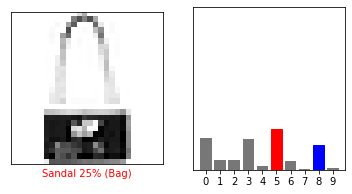

In [32]:
i = most_uncertain
row = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, first_five_hundred_preds[i].mean(), test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, first_five_hundred_preds[i].mean(),  test_labels)
plt.show()

You can see why a model might have some uncertainty there!

Let's allow the model now to use the uncertainty as an attribute in whether it makes a prediction. Now, instead of always outputting a class, we'll only make a prediction if the mean value minus twice the standard deviation is greater than some guard value.

In [33]:
guard_value = 0.25

max_preds = [max(pred.mean() - (pred.std() * 2)) for pred in first_five_hundred_preds]
predicted_preds = [(i, val) for i, val in enumerate(max_preds) if val > guard_value]

In [34]:
len(predicted_preds)

67

In [35]:
evaluate_indices = [predicted_pred[0] for predicted_pred in predicted_preds]

In [36]:
model.evaluate(test_images[evaluate_indices],  tf.keras.utils.to_categorical(test_labels[evaluate_indices]), verbose=2)

67/1 - 0s - loss: 749.3553 - accuracy: 0.8806


[709.3841060809235, 0.880597]

The model was able to boost its baseline accuracy significantly by recognizing those cases on which it's not confident and refusing to make a prediction! We can try higher values for this guard figure to see how being more stringent on permissable uncertainty affects the model's ultimate accuracy.

In [37]:
guard_value = 0.5

max_preds = [max(pred.mean() - (pred.std() * 2)) for pred in first_five_hundred_preds]
predicted_preds = [(i, val) for i, val in enumerate(max_preds) if val > guard_value]

evaluate_indices = [predicted_pred[0] for predicted_pred in predicted_preds]

model.evaluate(test_images[evaluate_indices],  tf.keras.utils.to_categorical(test_labels[evaluate_indices]), verbose=2)

37/1 - 0s - loss: 738.3701 - accuracy: 0.9459


[745.174290012669, 0.9459459]

## Takeaways

- We can use epistemic uncertainty in deep neural networks for tasks like image classification just as easily as we can for regresssion.
- Probabilistic uncertainty can be quantified directly by the variance in a large number of predictions from a model's potential classes
- A model can use this uncertainty itself to weed out instances it would rather not predict over and thereby raise its precision for the remaining instances.